# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'aapl.csv')
df = df.iloc[:, 1:]
df

,Open,High,Low,Close,Volume,Close_SMA10,Close_SMA20,Close_SMA30,Close_EMA10,Close_EMA20,...,Close_long,Close_MACD,Close_SignalLine,Close_7D,Close_1D,Close_Momentum,Close1diff,Close_up,Close_down,Close_RSI
0,151.78,151.78,151.78,151.78,195.0,151.802,151.8685,151.851000,151.814923,151.837962,...,151.846566,-0.025605,-0.016996,151.80,151.80,0.000000,-0.02,0.00,-0.02,37.096774
1,151.78,151.78,151.78,151.78,465.0,151.803,151.8640,151.846333,151.808574,151.832442,...,151.841635,-0.026976,-0.018992,151.80,151.78,-0.000132,0.00,0.00,0.00,33.898305
2,151.75,151.75,151.65,151.69,1877.0,151.787,151.8525,151.837333,151.787015,151.818876,...,151.830403,-0.034922,-0.022178,151.81,151.78,-0.000198,-0.09,0.00,-0.09,28.358209
3,151.62,151.62,151.60,151.62,913.0,151.769,151.8365,151.826667,151.756648,151.799935,...,151.814817,-0.046334,-0.027009,151.81,151.69,-0.000790,-0.07,0.00,-0.07,29.687500
4,151.66,151.66,151.65,151.65,441.0,151.754,151.8210,151.824000,151.737258,151.785656,...,151.802609,-0.052353,-0.032078,151.81,151.62,-0.001252,0.03,0.03,0.00,22.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66784,166.28,166.33,166.28,166.33,1020.0,166.340,166.3450,166.359333,166.323779,166.337186,...,166.336513,-0.007955,0.005171,166.40,166.28,-0.000721,0.05,0.05,0.00,51.162791
66785,166.33,166.33,166.30,166.30,327.0,166.325,166.3450,166.351333,166.319455,166.333645,...,166.333808,-0.009644,0.002208,166.33,166.33,0.000000,-0.03,0.00,-0.03,42.307692
66786,166.30,166.35,166.30,166.35,3435.0,166.323,166.3500,166.349333,166.325009,166.335203,...,166.335008,-0.006868,0.000393,166.40,166.30,-0.000601,0.05,0.05,0.00,45.121951
66787,166.33,166.40,166.33,166.40,1519.0,166.323,166.3515,166.348667,166.338644,166.341374,...,166.339822,-0.000627,0.000189,166.35,166.35,0.000000,0.05,0.05,0.00,47.674419


### If you want Feature Engineering for uni-stock

In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #Simple Moving Average
    def SMA(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        data[column+f'_SMA{period}'] = data[column].rolling(period).mean()
        return data
    
    def SMA_(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        return data[column].rolling(period).mean()

    #Exponential Moving Average
    def EMA(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        data[column+f'_EMA{period}'] = data[column].ewm(span=period, adjust=False).mean()
        return data
    
    def EMA_(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        return data[column].ewm(span=period, adjust=False).mean()
    
    #BollingerBand with SMA
    def Bollingerband(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_SMA{period}'] = self.SMA_(data, column=column, period=period)
        data[column+'_UB'] = data[column+f'_SMA{period}'] + 2*data[column+f'_SMA{period}'].std()
        data[column+'_LB'] = data[column+f'_SMA{period}'] - 2*data[column+f'_SMA{period}'].std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'_short'] = self.EMA_(data, period=period_short, column=column)

        data[column+f'_long'] = self.EMA_(data, period=period_long, column=column)

        data[column+'_MACD'] = data[column+f'_short']- data[column+f'_long']

        #signal
        data[column+'_SignalLine'] = self.EMA_(data, period=period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_{period}D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+f'_{period}D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'1diff'] = data[column].diff(1)
        
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA_(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA_(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = copy.deepcopy(train)
        c = self.stock_name
        
        self.train = self.SMA(self.train, column=c, period=10)
        self.train = self.SMA(self.train, column=c, period=20)
        self.train = self.SMA(self.train, column=c, period=30)
        
        self.train = self.EMA(self.train, column=c, period=10)
        self.train = self.EMA(self.train, column=c, period=20)
        self.train = self.EMA(self.train, column=c, period=30)
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
#fe = FeatureEngineering('AAPL')
#df_fe = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
#df = pd.concat([df_fe.iloc[:, 1:], df], axis=1)
#df.dropna(inplace=True)
target_loc = pd.Index(df.columns.tolist()).get_loc('Close')
print(target_loc, len(df.columns))

3 24


In [7]:
train = df[:60000]
valid = df[60000:60000+3800]
test = df[60000+3800:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

60000 3800 2989


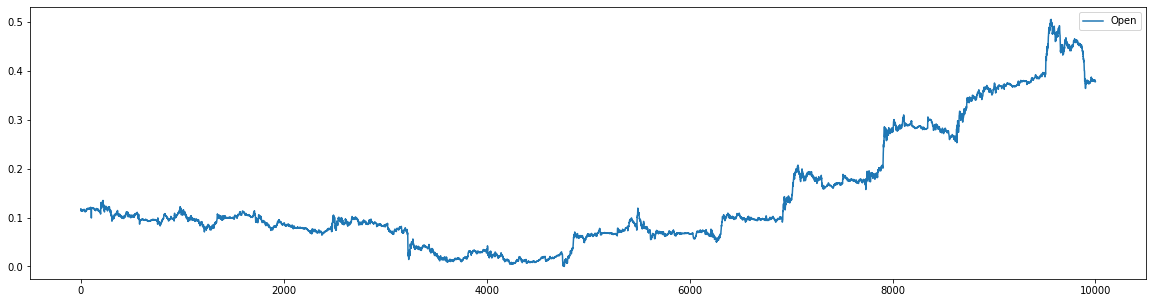

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, 0], label=train_sc.columns[0])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred, target_loc):
        self.data = torch.Tensor(data.values)
        self.window = window
        self.pred = pred
        self.target_loc = target_loc
        self.use_cols = [x for x in range(len(data.columns)) if x != target_loc] #if x != target_loc
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, self.use_cols]
        y = self.data[index+self.window+self.pred-1, self.target_loc]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4
window = 60
pred_step = 10

In [12]:
train_dataset = MyDataset(train_sc, window, pred_step, target_loc)
valid_dataset = MyDataset(valid_sc, window, pred_step, target_loc)
test_dataset = MyDataset(test_sc, window, pred_step, target_loc)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [13]:
result_folder = f'../check/gru/stock_prediction_{pred_step}_aapl/'
os.makedirs(result_folder, exist_ok=True)

In [14]:
class GRU(nn.Module):
    def __init__(self, in_features, out_features, hidden_dim):
        super(GRU, self).__init__()
        
        self.n_layers = 3
        self.hidden_size=hidden_dim
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.gru = nn.GRU(input_size=in_features, hidden_size=self.hidden_size, batch_first=True,
                          num_layers=self.n_layers, dropout=0.1)
        
        self.out = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            self.leakyrelu,
            nn.Linear(64, 32), 
            self.leakyrelu,
            nn.Linear(32, out_features)
        )
        
    def forward(self, x):
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, x.shape[0], self.hidden_size).zero_()
        
        rnn_output, h = self.gru(x,h)
        outputs = self.out(h[-1, :, :].squeeze(0))
        
        return outputs

In [15]:
model = GRU(in_features= 24-1,
            out_features=1, 
            hidden_dim = 256).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [16]:
model

GRU(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (gru): GRU(23, 256, num_layers=3, batch_first=True, dropout=0.1)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model Training & Evaluation #

In [17]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-stock-{epoch}.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'gru-pred-stock-best.pt')

epoch: 0/200 | trn_loss: 0.0356 | val_loss: 0.0136


epoch: 1/200 | trn_loss: 0.0132 | val_loss: 0.0127


epoch: 2/200 | trn_loss: 0.0129 | val_loss: 0.0124


epoch: 3/200 | trn_loss: 0.0124 | val_loss: 0.0127


epoch: 4/200 | trn_loss: 0.0123 | val_loss: 0.0120


epoch: 5/200 | trn_loss: 0.0121 | val_loss: 0.0121


epoch: 6/200 | trn_loss: 0.0120 | val_loss: 0.0125


epoch: 7/200 | trn_loss: 0.0117 | val_loss: 0.0120


epoch: 8/200 | trn_loss: 0.0117 | val_loss: 0.0118


epoch: 9/200 | trn_loss: 0.0114 | val_loss: 0.0119


epoch: 10/200 | trn_loss: 0.0115 | val_loss: 0.0119


epoch: 11/200 | trn_loss: 0.0112 | val_loss: 0.0128


epoch: 12/200 | trn_loss: 0.0113 | val_loss: 0.0132


epoch: 13/200 | trn_loss: 0.0112 | val_loss: 0.0128


epoch: 14/200 | trn_loss: 0.0113 | val_loss: 0.0122


epoch: 15/200 | trn_loss: 0.0112 | val_loss: 0.0118


epoch: 16/200 | trn_loss: 0.0111 | val_loss: 0.0118


epoch: 17/200 | trn_loss: 0.0112 | val_loss: 0.0139


epoch: 18/200 | trn_loss: 0.0110 | val_loss: 0.0144


epoch: 19/200 | trn_loss: 0.0110 | val_loss: 0.0118


epoch: 20/200 | trn_loss: 0.0110 | val_loss: 0.0133


epoch: 21/200 | trn_loss: 0.0108 | val_loss: 0.0118


epoch: 22/200 | trn_loss: 0.0109 | val_loss: 0.0142


epoch: 23/200 | trn_loss: 0.0109 | val_loss: 0.0123


epoch: 24/200 | trn_loss: 0.0108 | val_loss: 0.0124


epoch: 25/200 | trn_loss: 0.0108 | val_loss: 0.0117


epoch: 26/200 | trn_loss: 0.0108 | val_loss: 0.0128


epoch: 27/200 | trn_loss: 0.0108 | val_loss: 0.0118


epoch: 28/200 | trn_loss: 0.0107 | val_loss: 0.0118


epoch: 29/200 | trn_loss: 0.0107 | val_loss: 0.0124


epoch: 30/200 | trn_loss: 0.0107 | val_loss: 0.0119


epoch: 31/200 | trn_loss: 0.0106 | val_loss: 0.0118


epoch: 32/200 | trn_loss: 0.0108 | val_loss: 0.0122


epoch: 33/200 | trn_loss: 0.0106 | val_loss: 0.0134


epoch: 34/200 | trn_loss: 0.0107 | val_loss: 0.0122


epoch: 35/200 | trn_loss: 0.0108 | val_loss: 0.0131


epoch: 36/200 | trn_loss: 0.0106 | val_loss: 0.0118


epoch: 37/200 | trn_loss: 0.0106 | val_loss: 0.0117


epoch: 38/200 | trn_loss: 0.0106 | val_loss: 0.0118


epoch: 39/200 | trn_loss: 0.0105 | val_loss: 0.0126


epoch: 40/200 | trn_loss: 0.0106 | val_loss: 0.0117


epoch: 41/200 | trn_loss: 0.0105 | val_loss: 0.0117


epoch: 42/200 | trn_loss: 0.0105 | val_loss: 0.0125


epoch: 43/200 | trn_loss: 0.0106 | val_loss: 0.0117


epoch: 44/200 | trn_loss: 0.0105 | val_loss: 0.0121


epoch: 45/200 | trn_loss: 0.0104 | val_loss: 0.0134


epoch: 46/200 | trn_loss: 0.0105 | val_loss: 0.0119


epoch: 47/200 | trn_loss: 0.0105 | val_loss: 0.0117


epoch: 48/200 | trn_loss: 0.0106 | val_loss: 0.0117


epoch: 49/200 | trn_loss: 0.0104 | val_loss: 0.0119


epoch: 50/200 | trn_loss: 0.0104 | val_loss: 0.0119


epoch: 51/200 | trn_loss: 0.0104 | val_loss: 0.0119


epoch: 52/200 | trn_loss: 0.0104 | val_loss: 0.0120


epoch: 53/200 | trn_loss: 0.0103 | val_loss: 0.0121


epoch: 54/200 | trn_loss: 0.0105 | val_loss: 0.0120


epoch: 55/200 | trn_loss: 0.0104 | val_loss: 0.0118


epoch: 56/200 | trn_loss: 0.0103 | val_loss: 0.0119


epoch: 57/200 | trn_loss: 0.0103 | val_loss: 0.0119


epoch: 58/200 | trn_loss: 0.0103 | val_loss: 0.0134


epoch: 59/200 | trn_loss: 0.0104 | val_loss: 0.0129


epoch: 60/200 | trn_loss: 0.0103 | val_loss: 0.0118


epoch: 61/200 | trn_loss: 0.0103 | val_loss: 0.0121


epoch: 62/200 | trn_loss: 0.0103 | val_loss: 0.0140


epoch: 63/200 | trn_loss: 0.0103 | val_loss: 0.0119


epoch: 64/200 | trn_loss: 0.0102 | val_loss: 0.0138


epoch: 65/200 | trn_loss: 0.0102 | val_loss: 0.0128


epoch: 66/200 | trn_loss: 0.0102 | val_loss: 0.0124


epoch: 67/200 | trn_loss: 0.0103 | val_loss: 0.0130


epoch: 68/200 | trn_loss: 0.0102 | val_loss: 0.0123


epoch: 69/200 | trn_loss: 0.0103 | val_loss: 0.0120


epoch: 70/200 | trn_loss: 0.0102 | val_loss: 0.0122


epoch: 71/200 | trn_loss: 0.0102 | val_loss: 0.0120


epoch: 72/200 | trn_loss: 0.0101 | val_loss: 0.0129


epoch: 73/200 | trn_loss: 0.0102 | val_loss: 0.0121


epoch: 74/200 | trn_loss: 0.0101 | val_loss: 0.0120


epoch: 75/200 | trn_loss: 0.0102 | val_loss: 0.0123


epoch: 76/200 | trn_loss: 0.0101 | val_loss: 0.0121


epoch: 77/200 | trn_loss: 0.0101 | val_loss: 0.0124


epoch: 78/200 | trn_loss: 0.0102 | val_loss: 0.0121


epoch: 79/200 | trn_loss: 0.0100 | val_loss: 0.0122


epoch: 80/200 | trn_loss: 0.0101 | val_loss: 0.0138


epoch: 81/200 | trn_loss: 0.0101 | val_loss: 0.0125


epoch: 82/200 | trn_loss: 0.0100 | val_loss: 0.0127


epoch: 83/200 | trn_loss: 0.0100 | val_loss: 0.0121


epoch: 84/200 | trn_loss: 0.0100 | val_loss: 0.0120


epoch: 85/200 | trn_loss: 0.0099 | val_loss: 0.0123


epoch: 86/200 | trn_loss: 0.0099 | val_loss: 0.0121


epoch: 87/200 | trn_loss: 0.0100 | val_loss: 0.0129


epoch: 88/200 | trn_loss: 0.0099 | val_loss: 0.0120


epoch: 89/200 | trn_loss: 0.0100 | val_loss: 0.0123


epoch: 90/200 | trn_loss: 0.0100 | val_loss: 0.0127


epoch: 91/200 | trn_loss: 0.0098 | val_loss: 0.0125


epoch: 92/200 | trn_loss: 0.0098 | val_loss: 0.0129


epoch: 93/200 | trn_loss: 0.0098 | val_loss: 0.0123


epoch: 94/200 | trn_loss: 0.0098 | val_loss: 0.0135


epoch: 95/200 | trn_loss: 0.0098 | val_loss: 0.0123


epoch: 96/200 | trn_loss: 0.0097 | val_loss: 0.0123


epoch: 97/200 | trn_loss: 0.0097 | val_loss: 0.0123


epoch: 98/200 | trn_loss: 0.0098 | val_loss: 0.0131


epoch: 99/200 | trn_loss: 0.0098 | val_loss: 0.0129


epoch: 100/200 | trn_loss: 0.0097 | val_loss: 0.0135


epoch: 101/200 | trn_loss: 0.0097 | val_loss: 0.0128


epoch: 102/200 | trn_loss: 0.0097 | val_loss: 0.0123


epoch: 103/200 | trn_loss: 0.0096 | val_loss: 0.0132


epoch: 104/200 | trn_loss: 0.0097 | val_loss: 0.0131


epoch: 105/200 | trn_loss: 0.0096 | val_loss: 0.0126


epoch: 106/200 | trn_loss: 0.0096 | val_loss: 0.0126


epoch: 107/200 | trn_loss: 0.0095 | val_loss: 0.0130


epoch: 108/200 | trn_loss: 0.0096 | val_loss: 0.0126


epoch: 109/200 | trn_loss: 0.0095 | val_loss: 0.0128


epoch: 110/200 | trn_loss: 0.0094 | val_loss: 0.0129


epoch: 111/200 | trn_loss: 0.0095 | val_loss: 0.0126


epoch: 112/200 | trn_loss: 0.0094 | val_loss: 0.0126


epoch: 113/200 | trn_loss: 0.0094 | val_loss: 0.0127


epoch: 114/200 | trn_loss: 0.0093 | val_loss: 0.0130


epoch: 115/200 | trn_loss: 0.0094 | val_loss: 0.0128


epoch: 116/200 | trn_loss: 0.0093 | val_loss: 0.0134


epoch: 117/200 | trn_loss: 0.0093 | val_loss: 0.0130


epoch: 118/200 | trn_loss: 0.0093 | val_loss: 0.0131


epoch: 119/200 | trn_loss: 0.0093 | val_loss: 0.0132


epoch: 120/200 | trn_loss: 0.0092 | val_loss: 0.0137


epoch: 121/200 | trn_loss: 0.0092 | val_loss: 0.0134


epoch: 122/200 | trn_loss: 0.0092 | val_loss: 0.0131


epoch: 123/200 | trn_loss: 0.0090 | val_loss: 0.0136


epoch: 124/200 | trn_loss: 0.0091 | val_loss: 0.0134


epoch: 125/200 | trn_loss: 0.0090 | val_loss: 0.0136


epoch: 126/200 | trn_loss: 0.0090 | val_loss: 0.0136


epoch: 127/200 | trn_loss: 0.0089 | val_loss: 0.0137


epoch: 128/200 | trn_loss: 0.0089 | val_loss: 0.0142


epoch: 129/200 | trn_loss: 0.0089 | val_loss: 0.0136


epoch: 130/200 | trn_loss: 0.0089 | val_loss: 0.0133


epoch: 131/200 | trn_loss: 0.0089 | val_loss: 0.0136


epoch: 132/200 | trn_loss: 0.0088 | val_loss: 0.0137


epoch: 133/200 | trn_loss: 0.0088 | val_loss: 0.0136


epoch: 134/200 | trn_loss: 0.0087 | val_loss: 0.0137


epoch: 135/200 | trn_loss: 0.0087 | val_loss: 0.0137


epoch: 136/200 | trn_loss: 0.0087 | val_loss: 0.0139


epoch: 137/200 | trn_loss: 0.0086 | val_loss: 0.0137


epoch: 138/200 | trn_loss: 0.0086 | val_loss: 0.0145


epoch: 139/200 | trn_loss: 0.0085 | val_loss: 0.0144


epoch: 140/200 | trn_loss: 0.0085 | val_loss: 0.0149


epoch: 141/200 | trn_loss: 0.0085 | val_loss: 0.0148


epoch: 142/200 | trn_loss: 0.0084 | val_loss: 0.0145


epoch: 143/200 | trn_loss: 0.0084 | val_loss: 0.0143


epoch: 144/200 | trn_loss: 0.0084 | val_loss: 0.0150


epoch: 145/200 | trn_loss: 0.0084 | val_loss: 0.0145


epoch: 146/200 | trn_loss: 0.0083 | val_loss: 0.0145


epoch: 147/200 | trn_loss: 0.0083 | val_loss: 0.0144


epoch: 148/200 | trn_loss: 0.0083 | val_loss: 0.0152


epoch: 149/200 | trn_loss: 0.0082 | val_loss: 0.0146


epoch: 150/200 | trn_loss: 0.0082 | val_loss: 0.0149


epoch: 151/200 | trn_loss: 0.0081 | val_loss: 0.0148


epoch: 152/200 | trn_loss: 0.0082 | val_loss: 0.0160


epoch: 153/200 | trn_loss: 0.0082 | val_loss: 0.0157


epoch: 154/200 | trn_loss: 0.0081 | val_loss: 0.0153


epoch: 155/200 | trn_loss: 0.0081 | val_loss: 0.0152


epoch: 156/200 | trn_loss: 0.0080 | val_loss: 0.0154


epoch: 157/200 | trn_loss: 0.0080 | val_loss: 0.0155


epoch: 158/200 | trn_loss: 0.0080 | val_loss: 0.0150


epoch: 159/200 | trn_loss: 0.0080 | val_loss: 0.0156


epoch: 160/200 | trn_loss: 0.0079 | val_loss: 0.0154


epoch: 161/200 | trn_loss: 0.0078 | val_loss: 0.0152


epoch: 162/200 | trn_loss: 0.0078 | val_loss: 0.0149


epoch: 163/200 | trn_loss: 0.0078 | val_loss: 0.0154


epoch: 164/200 | trn_loss: 0.0078 | val_loss: 0.0157


epoch: 165/200 | trn_loss: 0.0078 | val_loss: 0.0157


epoch: 166/200 | trn_loss: 0.0077 | val_loss: 0.0155


epoch: 167/200 | trn_loss: 0.0076 | val_loss: 0.0154


epoch: 168/200 | trn_loss: 0.0076 | val_loss: 0.0154


epoch: 169/200 | trn_loss: 0.0075 | val_loss: 0.0158


epoch: 170/200 | trn_loss: 0.0075 | val_loss: 0.0155


epoch: 171/200 | trn_loss: 0.0075 | val_loss: 0.0159


epoch: 172/200 | trn_loss: 0.0074 | val_loss: 0.0156


epoch: 173/200 | trn_loss: 0.0074 | val_loss: 0.0159


epoch: 174/200 | trn_loss: 0.0073 | val_loss: 0.0161


epoch: 175/200 | trn_loss: 0.0074 | val_loss: 0.0168


epoch: 176/200 | trn_loss: 0.0073 | val_loss: 0.0158


epoch: 177/200 | trn_loss: 0.0072 | val_loss: 0.0161


epoch: 178/200 | trn_loss: 0.0071 | val_loss: 0.0158


epoch: 179/200 | trn_loss: 0.0072 | val_loss: 0.0159


epoch: 180/200 | trn_loss: 0.0072 | val_loss: 0.0163


epoch: 181/200 | trn_loss: 0.0072 | val_loss: 0.0161


epoch: 182/200 | trn_loss: 0.0070 | val_loss: 0.0162


epoch: 183/200 | trn_loss: 0.0071 | val_loss: 0.0166


epoch: 184/200 | trn_loss: 0.0070 | val_loss: 0.0160


epoch: 185/200 | trn_loss: 0.0070 | val_loss: 0.0162


epoch: 186/200 | trn_loss: 0.0069 | val_loss: 0.0162


epoch: 187/200 | trn_loss: 0.0069 | val_loss: 0.0162


epoch: 188/200 | trn_loss: 0.0069 | val_loss: 0.0163


epoch: 189/200 | trn_loss: 0.0068 | val_loss: 0.0162


epoch: 190/200 | trn_loss: 0.0068 | val_loss: 0.0162


epoch: 191/200 | trn_loss: 0.0067 | val_loss: 0.0163


epoch: 192/200 | trn_loss: 0.0067 | val_loss: 0.0167


epoch: 193/200 | trn_loss: 0.0067 | val_loss: 0.0168


epoch: 194/200 | trn_loss: 0.0066 | val_loss: 0.0166


epoch: 195/200 | trn_loss: 0.0065 | val_loss: 0.0168


epoch: 196/200 | trn_loss: 0.0065 | val_loss: 0.0162


epoch: 197/200 | trn_loss: 0.0065 | val_loss: 0.0168


epoch: 198/200 | trn_loss: 0.0065 | val_loss: 0.0168


epoch: 199/200 | trn_loss: 0.0064 | val_loss: 0.0164


epoch: 200/200 | trn_loss: 0.0063 | val_loss: 0.0162


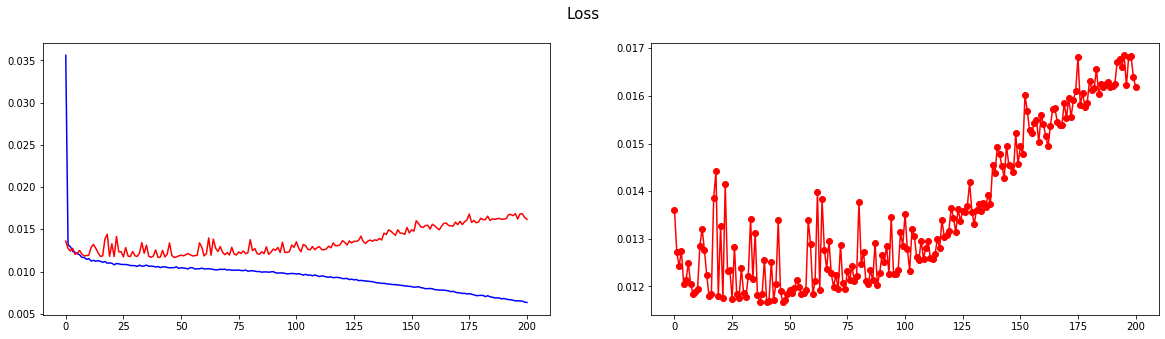

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'gru_loss.png')

In [19]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'gru_loss.csv', index=0)

### Performance Evaluation

In [20]:
checkpoint = torch.load(result_folder + 'gru-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

47 0.011665217321902767


In [21]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        answers.extend((y.squeeze()).squeeze().detach().cpu().numpy())
        predictions.extend((outputs.squeeze()).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

test loss: 0.009921019729834212


In [23]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
print(answers.shape, predictions.shape, test_sc.shape)

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

(2928, 24) (2928, 24) (2989, 24)


In [24]:
print(result_ans.shape)

(2928, 24)


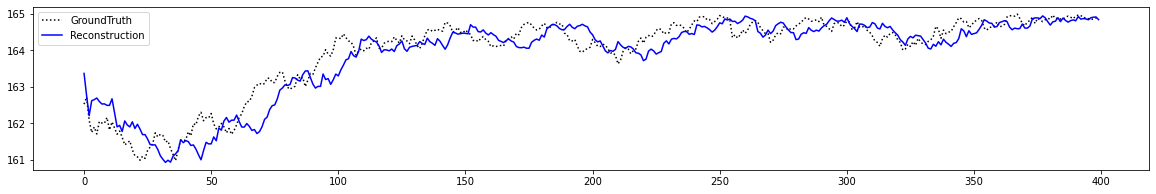

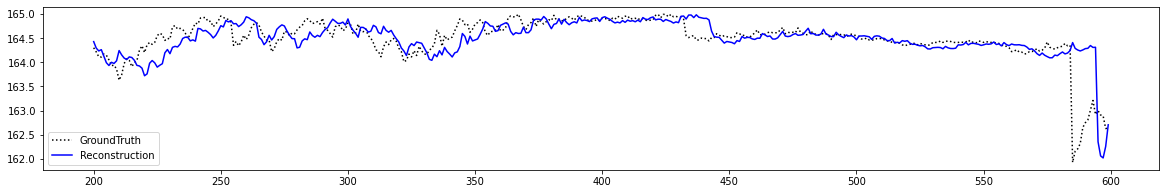

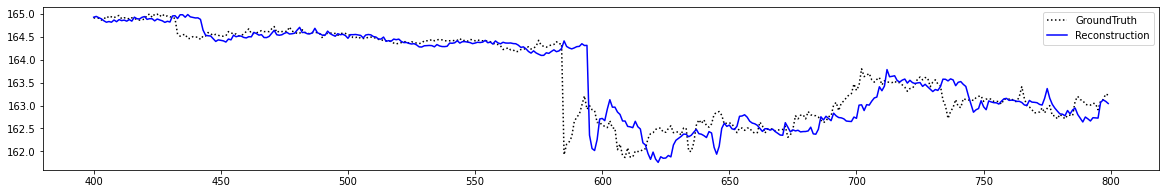

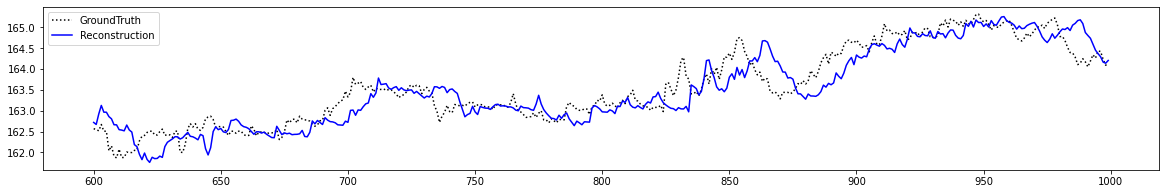

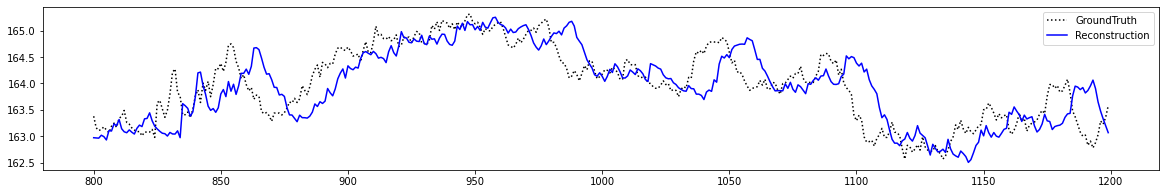

In [25]:
for i in range(0,1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()